# Capital Ring Walk Visualization

The aim of this notebook is to produce a nice visualization of the Capital Ring Walk [link](https://tfl.gov.uk/modes/walking/capital-ring). This was initially done to print on a mug, but the visualization is interesting in and of itself.

## Background

The Capital Ring Walk is a walking trail that encircles London. It is approximatly 80 miles in length, and is comprised of 15 continuous sections, which each and start and end at useful public transport (so the walk can be done in a series of easy trips).

Having walked the walk this year, I thought that visualising what I had done would be interesting. I had a background idea of printing the result onto a mug, so anything that played on the circular nature of the walk would be useful.

## Data Sources

- The map data used was downloaded from the Google Maps layer [here](https://www.google.com/maps/d/u/0/viewer?mid=1I6m2JRZPUh7H2eBWNfmkn7dkmcQ&hl=en_US&ll=51.50132010743988%2C-0.13801050000006398&z=12). This was exported as a KMZ file, which whas been included in the repository to make the notebook work
- Heights were found using [this tool](http://www.gpsvisualizer.com/geocoder/elevation.html), which uses the Google Maps location API to find the heights for a CSV list of points
- The opensource Railway sans font from https://github.com/GregFleming/Railway-Sans
- Colour values to use for tube lines were sourced [here](http://oobrien.com/2012/01/tube-colours/)

In [4]:
%matplotlib inline
from zipfile import ZipFile
from fastkml import kml
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString, MultiLineString, MultiPoint
from shapely.affinity import translate
import descartes
import re
import matplotlib.font_manager as font_manager
from cycler import cycler
import csv

## Step 1: Load the map data into the notebook

In [5]:
# Setup constants
map_data_file = 'map_data.kmz'

In [7]:
# Extract KML Data
kmz = ZipFile(map_data_file, 'r')
kml_file = kmz.open('doc.kml', 'r')

k = kml.KML()
k.from_string(kml_file.read())

features = list(k.features())
sections = list(features[0].features())

# Each section is represented as an XML object 
print(sections[0].to_string())

<kml:Placemark xmlns:kml="http://www.opengis.net/kml/2.2"><kml:name>Hendon Park to Highgate</kml:name><kml:description>8.5 km</kml:description><kml:visibility>1</kml:visibility><kml:styleUrl>#line-0000FF-5000</kml:styleUrl><kml:LineString><kml:coordinates>-0.224887,51.579550,0.000000 -0.223310,51.580337,0.000000 -0.221132,51.579303,0.000000 -0.217785,51.580697,0.000000 -0.215596,51.582457,0.000000 -0.214030,51.581603,0.000000 -0.213568,51.581943,0.000000 -0.212184,51.581250,0.000000 -0.211873,51.581623,0.000000 -0.211626,51.582250,0.000000 -0.211433,51.584483,0.000000 -0.210800,51.585510,0.000000 -0.211079,51.586750,0.000000 -0.211422,51.586996,0.000000 -0.211111,51.587310,0.000000 -0.209384,51.587396,0.000000 -0.207517,51.587570,0.000000 -0.204481,51.588403,0.000000 -0.200146,51.589310,0.000000 -0.194428,51.588036,0.000000 -0.193044,51.587470,0.000000 -0.190490,51.586630,0.000000 -0.189782,51.586050,0.000000 -0.187411,51.585650,0.000000 -0.183817,51.585257,0.000000 -0.181382,51.585003

## Step 2: Extract the data into a shapely shape for maniuplation

In this step, we convert the raw KML data into a set of shapely LineStrings. Then add some methods for plotting them on a graph so that we can see how the geometric operations we will do actually look.

In [8]:
lines = [LineString(section.geometry.coords) for section in sections[::2]]
# Since the section lines do not always line up in the KML file,
# manually create the boundary line
joined_lines = []
for line in lines:
    joined_lines += line.coords
joined_lines.append(joined_lines[0])
ringwalk_solid = Polygon(joined_lines)
ringwalk = ringwalk_solid.boundary

In [9]:
def plot_line(axes, line):
    """
        Plot a collection of shapely LineStrings on a Matplotlib axes object
        
        :param axes:  The axes to plot on
        :param lines: A shapely LineString
    """
    x, y = line.xy
    axes.plot(x, y, color="#6699cc", alpha=0.7, linewidth=3, solid_capstyle='round', zorder=3)

def plot_lines(axes, lines):
    """
        Plot a collection of shapely LineStrings on a Matplotlib axes object
        
        :param axes:  The axes to plot on
        :param lines: A list of shapely LineStrings (or a single MultiLineString)
    """
    for line in lines:
        plot_line(axes, line)

def plot_point(axes, point, *args, **kwargs):
    """
        Plot a shapely Point on a Matplotlib axes object. To make the point appear clearly,
        create a small circle around it and fill the circle in.
        
        :param axes:  The axes to plot on
        :param point: The point to plot
        
        Extra arguments are passed to descartes.PolygonPatch (so that the plotted point can be styled)
    """
    axes.add_patch(descartes.PolygonPatch(point.buffer(0.005), *args, **kwargs))

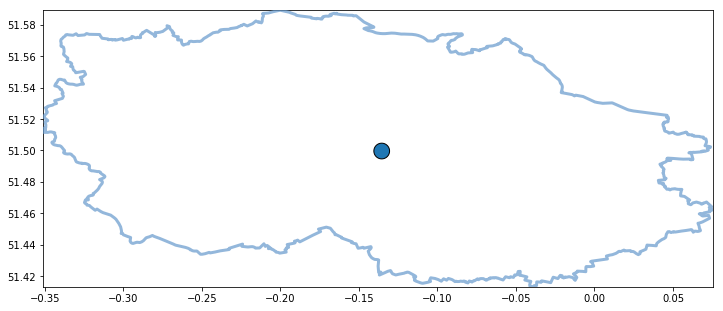

In [10]:
# Visualise the ringwalk to check that it looks as we expect, and find its centre
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(111)
plot_line(axes, ringwalk)
plot_point(axes, ringwalk.centroid)

# Tighten the frame around the ringwalk so that we save space
minx, miny, maxx, maxy = ringwalk.bounds
axes.set_xlim(minx, maxx)
axes.set_ylim(miny, maxy)
axes.set_aspect(1)
plt.show()

## Step 3: Finding intersections

Since we want to print the resulting visualization on a mug, we envisage the following design:

- A line on the mug that represents the height of the walk
- The visualization being lined up around the mug so that the height at a given angle is the height you would get from standing at the centre of the ringwalk and looking at that angle
- This line being divided into sections to make it clear what part of the walk it represents

Therfore, given an angle, we want to find the intersection between the line from the centroid at that angle and the ringwalk. Fortunately, shapely can handle interesections for us, if we are able to work out the line for ourselves.

In [11]:
def get_intersection(angle, geometry):
    """
        Given an angle and a shapely geometry, find the intersections between a line starting at the centroid
        of the geometry and moving outwards at the given angle, and the geometry itself
        
        :param angle:    The angle to aim at
        :param geometry: The geometry to intersect with
        
        :returns: A shapely geometry representing the intersection
    """
    # Pretend the angle is in the complex plane
    other_end_from_origin = 10* np.array([[np.cos(angle), ], [np.sin(angle), ]])
    
    angle_line = LineString([geometry.centroid, translate(geometry.centroid, 20*np.cos(angle), 20*np.sin(angle))])
    return angle_line.intersection(geometry)

def get_furthest_intersection(angle, geometry):
    """
        Given an angle and a shapely geometry, find the furthest single intersection between a line starting 
        at the centroid of the geometry and moving outwards at the given angle, with the geometry itself
        
        For parameter information, see get_intersection
        
        :returns: A shapely Point representing the intersection
    """
    intersection = get_intersection(angle, geometry)
    try:
        # Find the furthest intersection using the euclidian distance
        return max(intersection.geoms,
                   key=lambda point: np.sqrt(np.square(point.x - geometry.centroid.x) + 
                                             np.square(point.y - geometry.centroid.y)))
    except AttributeError:
        # If there is only a single point of intersection, then we will hit an AttributeError when
        # accessing its geoms property, but we can just return it directly instead
        return intersection

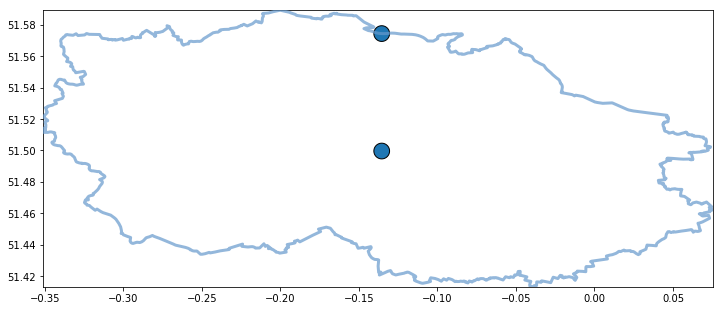

In [12]:
# To demonstrate the intersection method, add the point due North of the centroid to the
# map from before
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(111)
plot_line(axes, ringwalk)
plot_point(axes, ringwalk.centroid)
plot_point(axes, get_furthest_intersection(np.pi / 2, ringwalk))

minx, miny, maxx, maxy = ringwalk.bounds
axes.set_xlim(minx, maxx)
axes.set_ylim(miny, maxy)
axes.set_aspect(1)
plt.show()

## Step 4: Working out what angles to use

For the visualization, we want the height line to look suitably "blocky". At a guess, this would mean that we want about 10 points of height between each section. We can come back and change this later if needed.

Since we want the points to be evenly spaced, we need to:
- Work out the angles for each of the section endpoints
- Divide the arcs between the section endpoints into 10 equal sub-arcs for each section

In [14]:
# Find the angles for each section. To do this, we translate the section endpoints around zero and 
# work out their angle in the complex plane
section_starts = [Point(section.geometry.coords[0]) for section in sections[::2]]
starts_around_zero = [translate(coord, -ringwalk.centroid.x, -ringwalk.centroid.y) for coord in section_starts]
section_angles = np.angle([coord.x + (coord.y * 1j) for coord in starts_around_zero])
print("Section angles: {0}".format(section_angles))

Section angles: [ 2.41210635  1.71491671  0.80087096  0.36362836  0.06206879 -0.02613201
 -0.19671771 -0.38996047 -0.91561215 -1.58991889 -2.35210036 -2.90210368
 -3.1281093   2.93758895  2.75127883]


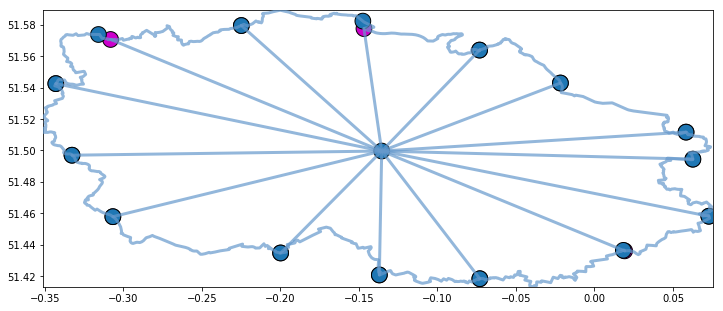

In [15]:
# Illustrate the process of finding the section endpoints
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(111)

# Add the ringwalk
plot_line(axes, ringwalk)
plot_point(axes, ringwalk.centroid)

# Add the section endpoints
for endpoint in section_starts:
    plot_point(axes, endpoint, fc='#cc00cc')

# Add the lines between the endpoints and the section endpoints
plot_lines(axes, [LineString([ringwalk.centroid, endpoint]) for endpoint in section_starts])

# Plot the intersections for the section angles
for angle in section_angles:
    plot_point(axes, get_furthest_intersection(angle, ringwalk))

minx, miny, maxx, maxy = ringwalk.bounds
axes.set_xlim(minx, maxx)
axes.set_ylim(miny, maxy)
axes.set_aspect(1)
plt.show()

As we can see from the above, the intersections do not exactly line up with the endpoints, but since the angles are evidently correct it does not matter too much. 

In [17]:
# Find the intersections at each of the sub-arcs between the sections.
# Store them as an array of (angle, intersection) tuples
coordinates = []

# Iterate through pairs of section angles, and find the 10 subarcs between them
for start_angle, end_angle in zip(section_angles, np.concatenate([section_angles[1:],
                                                                  section_angles[:1]])):
    # Since the sections are in a clockwise direction, they will
    # decrease, but catch the jump from -PI to PI
    if end_angle > start_angle:
        end_angle -= 2 * np.pi

    print("Adding subarcs from {0} to {1}".format(start_angle, end_angle))
    for x in np.linspace(start_angle, end_angle, num=10, endpoint=False):
        coordinates.append((x, get_furthest_intersection(x, ringwalk)))

print("We have {0} coordinates (150 expected)".format(len(coordinates)))

Adding subarcs from 2.4121063482049934 to 1.7149167076209706
Adding subarcs from 1.7149167076209706 to 0.8008709557389181
Adding subarcs from 0.8008709557389181 to 0.3636283592353533
Adding subarcs from 0.3636283592353533 to 0.06206878634426692
Adding subarcs from 0.06206878634426692 to -0.02613201493390642
Adding subarcs from -0.02613201493390642 to -0.19671771404816144
Adding subarcs from -0.19671771404816144 to -0.38996046891354935
Adding subarcs from -0.38996046891354935 to -0.9156121479336659
Adding subarcs from -0.9156121479336659 to -1.5899188913116153
Adding subarcs from -1.5899188913116153 to -2.352100358086768
Adding subarcs from -2.352100358086768 to -2.902103675951527
Adding subarcs from -2.902103675951527 to -3.1281093024497304
Adding subarcs from -3.1281093024497304 to -3.345596356605818
Adding subarcs from 2.9375889505737685 to 2.7512788267707067
Adding subarcs from 2.7512788267707067 to 2.4121063482049934
We have 150 coordinates (150 expected)


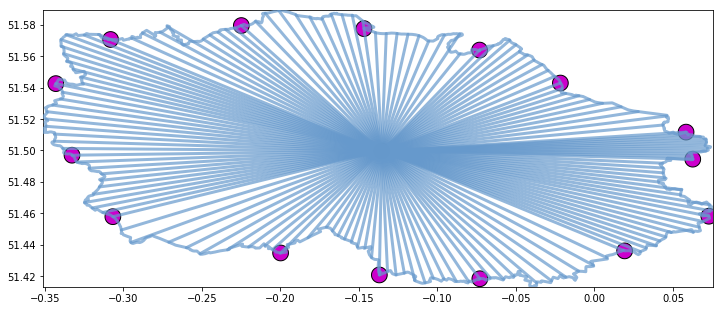

In [18]:
# Illustrate the process of finding the section endpoints
fig = plt.figure(figsize=(12,12))
axes = fig.add_subplot(111)

# Add the ringwalk
plot_line(axes, ringwalk)
plot_point(axes, ringwalk.centroid)

# Add the section endpoints
for endpoint in section_starts:
    plot_point(axes, endpoint, fc='#cc00cc')

# Add the lines between the endpoints and the section endpoints
plot_lines(axes, [LineString([ringwalk.centroid, coordinate[1]]) for coordinate in coordinates])

minx, miny, maxx, maxy = ringwalk.bounds
axes.set_xlim(minx, maxx)
axes.set_ylim(miny, maxy)
axes.set_aspect(1)
plt.show()

## Step 5: Get the heights for each point

Since Google Maps KML files do not include the height data for each point, we use the tool [here](http://www.gpsvisualizer.com/geocoder/elevation.html) to get the heights for each intersection.

This could be done by directly querying the Google Maps API, but that is beyond the scope of this visualization.

In [29]:
# Print out a CSV of coordinates, and then input the output from the tool
tool_input = ""

for coordinate in list(zip(*coordinates))[1]:
    tool_input += "{0},{1}\n".format(coordinate.x, coordinate.y)

with open("tool_output.csv", "r") as tool_output_file:
    tool_output = list(csv.DictReader(tool_output_file))

print(tool_output[0])

OrderedDict([('latitude', '-0.22488'), ('longitude', '51.57951'), ('elevation', '-5113.1')])


In [31]:
# Add the heights to the coordinates from the CSV data
coordinates_with_heights = []
for coordinate, line in zip(coordinates, tool_output):
    coordinates_with_heights.append((coordinate[0],
                                     Point([coordinate[1].x,
                                            coordinate[1].y,
                                            float(line['elevation'])])))

# We only care about relative height, so get the base to work with
base_height = min([coord.z for coord in list(zip(*coordinates_with_heights))[1]])
print(base_height)

-5115.3


## Step 6: Create the Visualization

To create the visualization, we need to plot a few things:
- A line giving the height of the ringwalk at all angles
- Lines representing the section boundaries
- The names of the sections

In [35]:
# Get a list of x,y coordinates that we can plot where:
# - x is the angle of the intersection
# - y is the relative height of the intersection
angles = list(zip(*coordinates_with_heights))[0]
relative_heights = [coord.z - base_height for coord in list(zip(*coordinates_with_heights))[1]]
tuples = sorted(list(zip(angles, relative_heights)),
                key=lambda x: x[0])

In [36]:
# Create a set of colours that correspond to the tube map (for visual appeal)
tube_colours = cycler('color', ['#B36305', '#E32017', '#FFD300', '#00782A',
                                '#F3A9BB', '#A0A5A9', '#9B0056', '#003688',
                                '#0098D4', '#95CDBA', '#00A4A7', '#EE7C0E',
                                '#84B817', '#E21836', '#7156A5'])

# Make railway sans usable as a font
prop = font_manager.FontProperties(fname="Railway.ttf")

# Create a regex we can use to parse "X to Y" format section titles
name_regex = re.compile(r'([\w ]+) to ([\w ]+)')
print(name_regex.match(sections[0].name).groups())

('Hendon Park', 'Highgate')


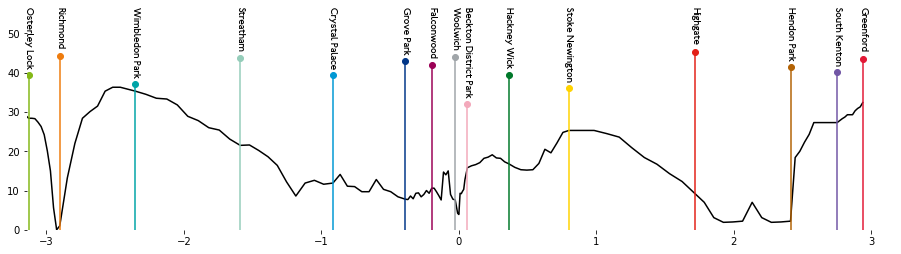

In [37]:
# Create the visualization

# Setup axes
fig = plt.figure(figsize=(12,3))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(0, 55)

# Add the height line
ax.plot(list(zip(*tuples))[0], list(zip(*tuples))[1], 'k-')

# Add the section markers
for section, angle, colour in zip(sections[::2], section_angles, tube_colours):
    # Add the section text
    text = ax.text(angle, 55,
                   name_regex.match(section.name).groups()[0],
                   rotation=270,
                   horizontalalignment='center', fontproperties=prop)
    
    # Add a line ending in a dot at the end of the text that extends to the bottom of the canvas
    line_end = ((text.get_window_extent(renderer=fig.canvas.get_renderer()).ymin /
                ax.get_window_extent(renderer=fig.canvas.get_renderer()).ymax) - 
               (1. / 55))
    ax.axvline(angle,
               0,
               line_end, c=colour['color'])
    ax.plot(angle, line_end * 55, 'o', c=colour['color'])

plt.show()